In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from joblib import dump, load
from skimage.feature import local_binary_pattern
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [2]:
# parameter settings
dataset_dir = 'Aerial_Landscapes'
categories = ['Agriculture', 'Airport', 'Beach', 'City', 'Desert', 'Forest', 'Grassland',
              'Highway', 'Lake', 'Mountain', 'Parking', 'Port', 'Railway', 'Residential', 'River']

lbp_radius = 1
lbp_n_points = 8 * lbp_radius
lbp_method = 'uniform'
resize_size = (128, 128)

In [3]:
# extract LBP features
def extract_lbp_features(img_gray):
    lbp = local_binary_pattern(img_gray, lbp_n_points, lbp_radius, lbp_method)
    hist, _ = np.histogram(lbp.ravel(),
                           bins=np.arange(0, lbp_n_points + 3),
                           range=(0, lbp_n_points + 2))
    hist = hist.astype("float")
    hist /= hist.sum()
    return hist

In [4]:
# load image data
features = []
labels = []

In [5]:
for category in tqdm(categories):
    folder_path = os.path.join(dataset_dir, category)
    for img_name in os.listdir(folder_path):
        img_path = os.path.join(folder_path, img_name)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            continue
        img = cv2.resize(img, resize_size)
        lbp_feature = extract_lbp_features(img)
        features.append(lbp_feature)
        labels.append(category)

100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:31<00:00,  2.12s/it]


In [6]:
# convert to a NumPy array
X = np.array(features)
le = LabelEncoder()
y = le.fit_transform(labels)

In [7]:
# split into training/testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [8]:
# train the model
clf = SVC(kernel='rbf', C=10, gamma='scale', probability=True)
clf.fit(X_train, y_train)

SVC(C=10, probability=True)

In [9]:
# save the model and label encoder
dump(clf, 'lbp_svm_model.joblib')
dump(le, 'label_encoder.joblib')
print("Model saved as lbp_svm_model.joblib and label_encoder.joblib")

Model saved as lbp_svm_model.joblib and label_encoder.joblib


In [10]:
# model evaluation
y_pred = clf.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print(f"Accuracy: {acc:.4f}")
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=le.classes_))

Accuracy: 0.5542
Classification Report:
              precision    recall  f1-score   support

 Agriculture       0.54      0.61      0.57       168
     Airport       0.37      0.35      0.36       161
       Beach       0.56      0.35      0.43       156
        City       0.56      0.55      0.55       170
      Desert       0.62      0.46      0.53       173
      Forest       0.77      0.87      0.82       163
   Grassland       0.78      0.74      0.76       165
     Highway       0.49      0.48      0.49       148
        Lake       0.59      0.46      0.51       157
    Mountain       0.46      0.65      0.54       156
     Parking       0.60      0.73      0.66       149
        Port       0.63      0.58      0.61       155
     Railway       0.56      0.55      0.56       152
 Residential       0.51      0.56      0.54       170
       River       0.33      0.36      0.34       157

    accuracy                           0.55      2400
   macro avg       0.56      0.55      0

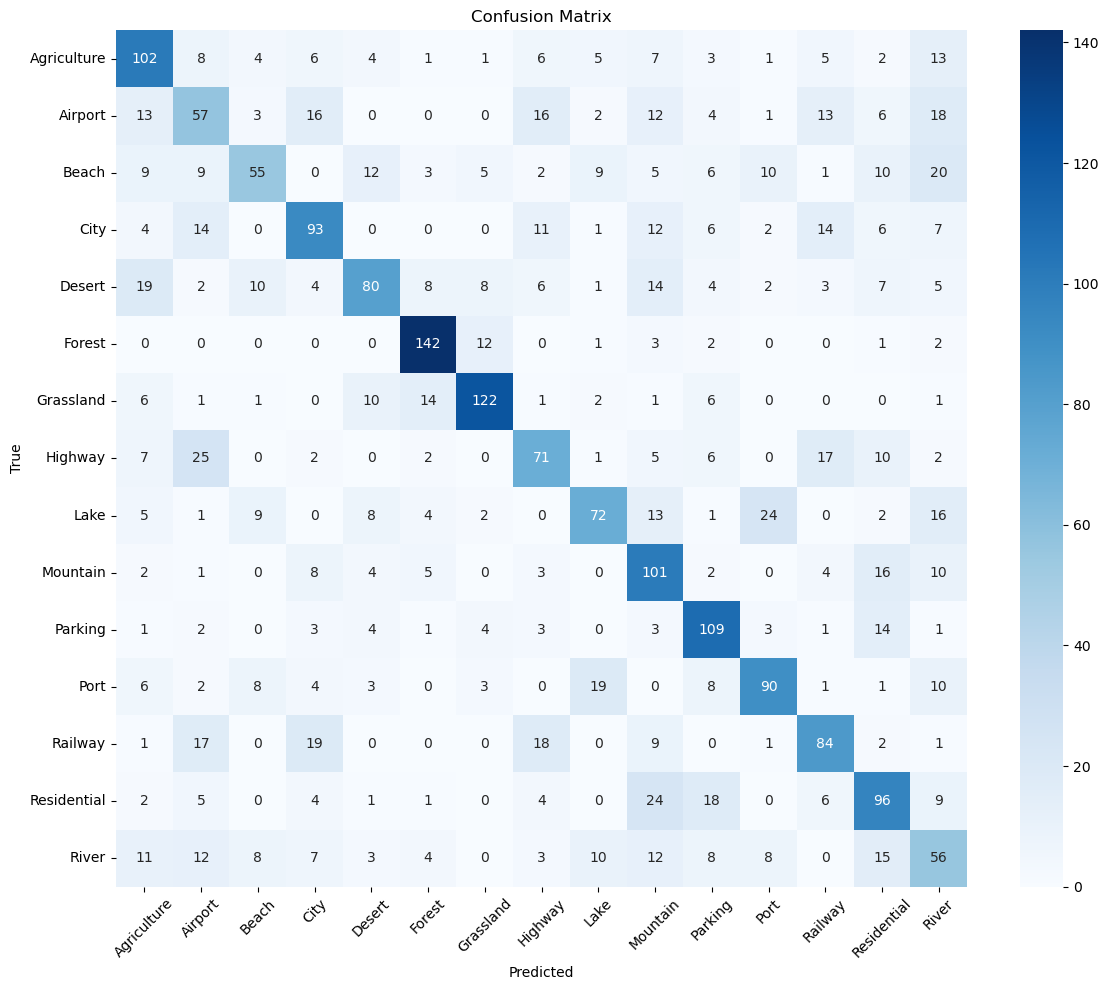

In [11]:
# plot the confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("confusion_matrix.png")
plt.show()

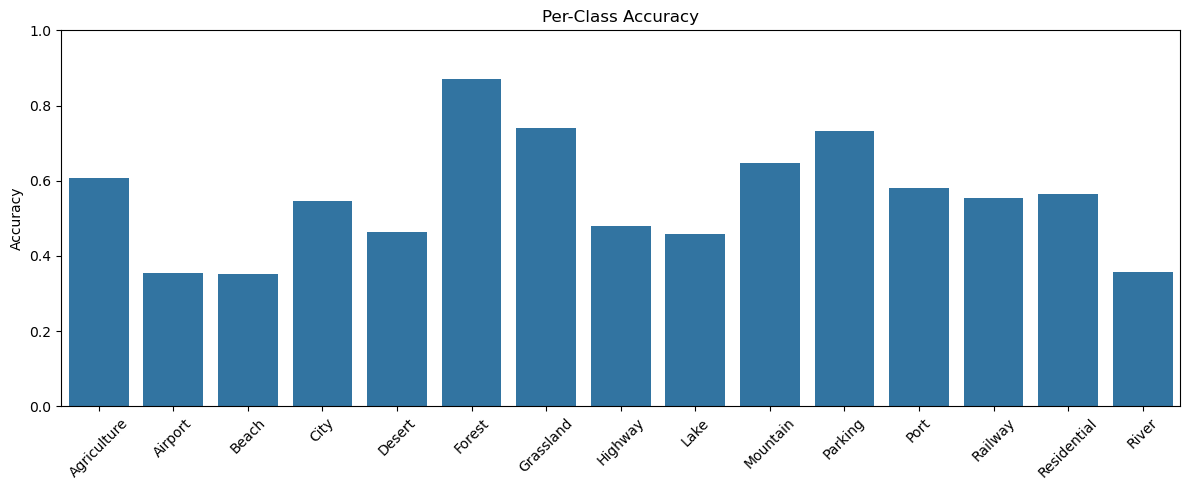

In [12]:
# plot a bar chart of accuracy per class
class_accuracy = cm.diagonal() / cm.sum(axis=1)
plt.figure(figsize=(12, 5))
sns.barplot(x=le.classes_, y=class_accuracy)
plt.ylabel("Accuracy")
plt.title("Per-Class Accuracy")
plt.xticks(rotation=45)
plt.ylim(0, 1.0)
plt.tight_layout()
plt.savefig("per_class_accuracy.png")
plt.show()